In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['Set'] = 'test'
train['Set'] = 'train'
test['SalePrice'] = 0
data_all = train.append(test)
data_all.reset_index(inplace = True)

<AxesSubplot:>

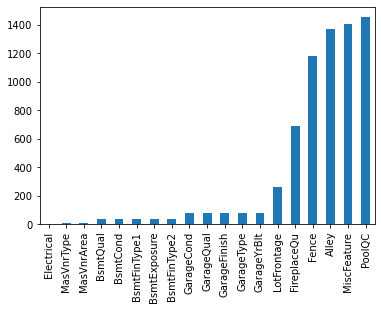

In [3]:
train[train.columns[train.isna().sum()>0]].isna().sum().sort_values().plot.bar()

<AxesSubplot:>

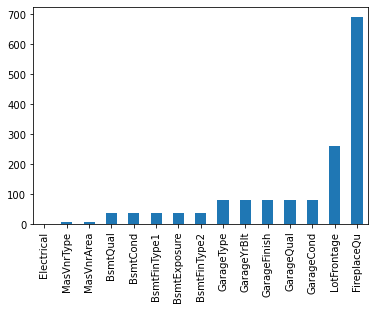

In [4]:
train_1 = train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
train_1[train_1.columns[train_1.isna().sum()>0]].isna().sum().sort_values().plot.bar()

In [5]:
def FillNa(data):
    cols = data.columns.values
    for i in range(0, len(data.columns)):
        name = cols[i]
        freq_val = data[name].mode()[0]
        data[name].fillna(freq_val, inplace = True)
    return data

In [6]:
train_cleaned = FillNa(train_1)
train_cleaned

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Set
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,train
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,train
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,train
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000,train
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,8,2007,WD,Normal,175000,train
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2010,WD,Normal,210000,train
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,2500,5,2010,WD,Normal,266500,train
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,4,2010,WD,Normal,142125,train


<AxesSubplot:>

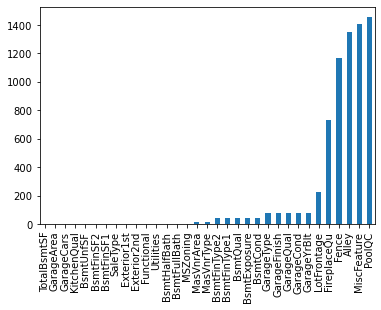

In [7]:
test[test.columns[test.isna().sum()>0]].isna().sum().sort_values().plot.bar()

<AxesSubplot:>

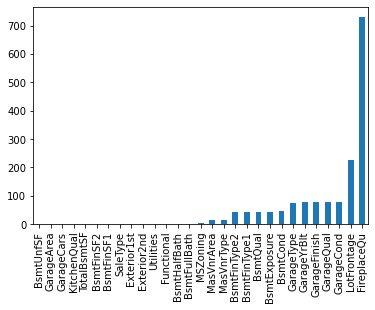

In [8]:
test_1 = test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
test_1[test_1.columns[test_1.isna().sum()>0]].isna().sum().sort_values().plot.bar()

In [9]:
test_cleaned = FillNa(test_1)
test_cleaned

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Set,SalePrice
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,120,0,0,6,2010,WD,Normal,test,0
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,12500,6,2010,WD,Normal,test,0
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,3,2010,WD,Normal,test,0
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,6,2010,WD,Normal,test,0
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,0,144,0,0,1,2010,WD,Normal,test,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,6,2006,WD,Normal,test,0
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,4,2006,WD,Abnorml,test,0
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,9,2006,WD,Abnorml,test,0
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,700,7,2006,WD,Normal,test,0


In [10]:
data_all = train_cleaned.append(test_cleaned)
data_all.reset_index(inplace=True)

In [11]:
data_all['BsmtFinSF'] = data_all.BsmtFinSF1 + data_all.BsmtFinSF2
data_all['Porch'] = data_all.ScreenPorch + data_all.EnclosedPorch + data_all.OpenPorchSF + data_all.WoodDeckSF
data_all['Total_surface'] = data_all.TotalBsmtSF + data_all['1stFlrSF'] + data_all['2ndFlrSF']
data_all['Age'] = data_all.YrSold - data_all.YearBuilt
data_all['RemodAge'] = data_all.YrSold - data_all.YearRemodAdd
data_all['GarageAge'] = data_all.YrSold - data_all.GarageYrBlt

In [12]:
data_all.columns.values

array(['index', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [13]:
drop_cols = ['BsmtFinSF1','BsmtFinSF2','LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
             'MiscVal','MoSold','YrSold','1stFlrSF','2ndFlrSF' ,'BsmtUnfSF','TotalBsmtSF', 'YearBuilt','YearRemodAdd',
            'BsmtHalfBath']
data_all.drop(drop_cols, inplace = True, axis=1)

In [14]:
categorical = sorted(['MSSubClass','MSZoning','Street','LotShape','LandContour','LandSlope','Neighborhood',
               'BldgType','HouseStyle','RoofStyle','RoofMatl','MasVnrType','Foundation','BsmtQual',
               'BsmtCond','BsmtExposure','Heating','CentralAir','Electrical', 
               'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd', 'Functional','Fireplaces','GarageType','GarageFinish',
                 'PavedDrive', 'SaleType','SaleCondition','LotConfig', 'Utilities','OverallCond','ExterCond'])
data_all[categorical] = data_all[categorical].astype('category')

In [15]:
marks = {"No":-1, "Po": 0, 'Fa': 1, "TA": 2, 'Gd': 3, 'Ex': 4}

def mark_to_num(mark):
    return marks[mark]

data_all['ExterQual'] = data_all['ExterQual'].apply(mark_to_num)
data_all['ExterCond'] = data_all['ExterCond'].apply(mark_to_num)
data_all['HeatingQC'] = data_all['HeatingQC'].apply(mark_to_num)
data_all['KitchenQual'] = data_all['KitchenQual'].apply(mark_to_num)
data_all['FireplaceQu'] = data_all['FireplaceQu'].apply(mark_to_num)
data_all['GarageQual'] = data_all['GarageQual'].apply(mark_to_num)
data_all['GarageCond'] = data_all['GarageCond'].apply(mark_to_num)

In [16]:
numeric = sorted(['LotFrontage','LotArea','MasVnrArea','BsmtFinSF','GrLivArea','GarageArea','Porch','Total_surface', 'Age','RemodAge','OverallQual', 'GarageCars','GarageAge', 
           'ExterQual','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond',
                 'BsmtFullBath','FullBath','HalfBath',])
data_all[numeric] = data_all[numeric].astype('float')

In [17]:
data_all[numeric]

,Age,BsmtFinSF,BsmtFullBath,ExterQual,FireplaceQu,FullBath,GarageAge,GarageArea,GarageCars,GarageCond,...,HalfBath,HeatingQC,KitchenQual,LotArea,LotFrontage,MasVnrArea,OverallQual,Porch,RemodAge,Total_surface
0,5.0,706.0,1.0,3.0,3.0,2.0,5.0,548.0,2.0,2.0,...,1.0,4.0,3.0,8450.0,65.0,196.0,7.0,61.0,5.0,2566.0
1,31.0,978.0,0.0,2.0,2.0,2.0,31.0,460.0,2.0,2.0,...,0.0,4.0,2.0,9600.0,80.0,0.0,6.0,298.0,31.0,2524.0
2,7.0,486.0,1.0,3.0,2.0,2.0,7.0,608.0,2.0,2.0,...,1.0,4.0,3.0,11250.0,68.0,162.0,7.0,42.0,6.0,2706.0
3,91.0,216.0,1.0,2.0,3.0,1.0,8.0,642.0,3.0,2.0,...,0.0,3.0,3.0,9550.0,60.0,0.0,7.0,307.0,36.0,2473.0
4,8.0,655.0,1.0,3.0,2.0,2.0,8.0,836.0,3.0,2.0,...,1.0,4.0,3.0,14260.0,84.0,350.0,8.0,276.0,8.0,3343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,36.0,0.0,0.0,2.0,3.0,1.0,1.0,0.0,0.0,2.0,...,1.0,3.0,2.0,1936.0,21.0,0.0,4.0,0.0,36.0,1638.0
2915,36.0,252.0,0.0,2.0,3.0,1.0,36.0,286.0,1.0,2.0,...,1.0,2.0,2.0,1894.0,21.0,0.0,4.0,24.0,36.0,1638.0
2916,46.0,1224.0,1.0,2.0,2.0,1.0,46.0,576.0,2.0,2.0,...,0.0,4.0,2.0,20000.0,160.0,0.0,5.0,474.0,10.0,2448.0
2917,14.0,337.0,0.0,2.0,3.0,1.0,1.0,0.0,0.0,2.0,...,0.0,2.0,2.0,10441.0,62.0,0.0,5.0,112.0,14.0,1882.0


In [18]:
mm = StandardScaler()
data_all[numeric] = mm.fit_transform(data_all[numeric])

In [19]:
data_1 = data_all.copy()
data_1['Condition1'] = data_1['Condition1'].map({'Artery':0,'RRAn':1,'PosA':2,'Feedr':3,'RRAe':4, 'RRNn':5,'PosN':6,'Norm':7, 'RRNe': 8})
data_1['Condition2'] = data_1['Condition2'].map({'Artery':0,'RRAn':1,'PosA':2,'Feedr':3,'RRAe':4, 'RRNn':5,'PosN':6,'Norm':7})
data_1[['Condition1', 'Condition2']]

,Condition1,Condition2
0,7,7
1,3,7
2,7,7
3,7,7
4,7,7
...,...,...
2914,7,7
2915,7,7
2916,7,7
2917,7,7


In [20]:
cond = data_all[['Exterior1st','Exterior2nd']]
condition_cats_1 = [s for s in set([*cond.Exterior2nd.unique()])]
condition_cats_1

['CBlock',
 'Other',
 'VinylSd',
 'AsphShn',
 'HdBoard',
 'ImStucc',
 'Wd Shng',
 'MetalSd',
 'Plywood',
 'BrkFace',
 'CmentBd',
 'AsbShng',
 'Brk Cmn',
 'Wd Sdng',
 'Stucco',
 'Stone']

In [21]:
data_2 = data_1.copy()
data_2['Exterior1st'] = data_2['Exterior1st'].map({'ImStucc':0,'CemntBd':1,'HdBoard':2,'Wd Sdng':3,'WdShing':4, 
                                                 'Stone':5,'VinylSd':6,'MetalSd':7, 'BrkFace':8,'BrkComm':9,'CBlock':10,
                                                 'AsbShng':11,'AsphShn':12,'Plywood':13, 'Stucco':14})
data_2['Exterior2nd'] = data_2['Exterior2nd'].map({'ImStucc':0,'CemntBd':1,'HdBoard':2,'Wd Sdng':3,'WdShing':4, 
                                                 'Stone':5,'VinylSd':6,'MetalSd':7, 'BrkFace':8,'BrkComm':9,'CBlock':10,
                                                 'AsbShng':11,'AsphShn':12,'Plywood':13, 'Stucco':14, 'Wd Shng':15, 'CmentBd':16,'Brk Cmn':17, 'Other':18})
data_2[['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
0,6,6
1,7,7
2,6,6
3,3,15
4,6,6
...,...,...
2914,1,16
2915,1,16
2916,6,6
2917,2,15


In [22]:
data_3 = data_2.copy()
data_3['BsmtFinType1'] = data_3['BsmtFinType1'].map({'LwQ':0,'BLQ':1,'Rec':2,'Unf':3,'ALQ':4,'GLQ':5})
data_3['BsmtFinType2'] = data_3['BsmtFinType2'].map({'LwQ':0,'BLQ':1,'Rec':2,'Unf':3,'ALQ':4,'GLQ':5})
data_3[['BsmtFinType1', 'BsmtFinType1']]

,BsmtFinType1,BsmtFinType1
0,5,5
1,4,4
2,5,5
3,4,4
4,5,5
...,...,...
2914,3,3
2915,2,2
2916,4,4
2917,5,5


In [23]:
data_4 = pd.get_dummies(data_3,columns=categorical)

In [24]:
train_cleaned = data_4[data_4.Set == 'train']
test_cleaned = data_4[data_4.Set == 'test']

In [25]:
HouseIds = test_cleaned.Id.to_list()
test_cleaned = test_cleaned.drop(['Id','Set',"SalePrice",'index'], axis = 1)
y = train_cleaned.SalePrice
X = train_cleaned.drop(['SalePrice','Id','Set','index'], axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 13)

In [27]:
RF_model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13).fit(X_train,y_train)
print("Random Forest:")
print("train_score:", RF_model.score(X_train,y_train))
print("test_score:", RF_model.score(X_test,y_test))

Random Forest:
train_score: 0.9800794464165141
test_score: 0.8783231721936229


In [30]:

param_grid = {'n_estimators': [500, 1000],'max_depth': [None], 'max_features':['auto','log2','sqrt']}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=13, n_jobs=-1), param_grid, cv=4)
rf_grid.fit(X, y)
print(rf_grid.best_estimator_)
print(rf_grid.best_params_)
rf_score = rf_grid.best_score_
print(rf_score) 

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13)
{'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
0.86437399394618


array([126330.208, 163832.742, 179802.386, ..., 164211.252, 117442.416,
       225301.644])

In [31]:
param_grid = {'n_estimators': [500],'max_depth': [None], 'max_features':['auto']}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=13, n_jobs=-1), param_grid, cv=4)
rf_grid.fit(X, y)
print(rf_grid.best_estimator_)
print(rf_grid.best_params_)
rf_score = rf_grid.best_score_
print(rf_score) 
predicted_RF = rf_grid.predict(test_cleaned)
predicted_RF

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13)
{'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
0.86437399394618


array([126330.208, 163832.742, 179802.386, ..., 164211.252, 117442.416,
       225301.644])

In [ ]:
clf = XGBRegressor()
predicted_XGB = cross_val_predict(clf, X_test, y_test,  cv = 5)

In [ ]:
results = pd.DataFrame({"Id":test.Id, 'SalePrice':predicted_RF})
results.head(10)

In [ ]:
results.to_csv('submission.csv', index=False)